# [7] Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, Apply Naive Bayes on it by converting review to vector using TF-IDF, Find Confusion Matrix, F1-Score, Precision value , Recall Value


## [7.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [50]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer



# using the SQLite Table to read data.
con = sqlite3.connect(r'C:\Users\hp\Downloads\amazon-fine-food-reviews\database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 






In [51]:
filtered_data['Score'] = filtered_data['Score'].apply(lambda x : 'pos' if x > 3 else 'neg')

In [52]:
filtered_data['Time'].head(2)

0    1303862400
1    1346976000
Name: Time, dtype: int64

In [53]:
import datetime
filtered_data["Time"] = filtered_data["Time"].map(lambda t: datetime.datetime.fromtimestamp(int(t)).strftime('%Y-%m-%d %H:%M:%S'))



In [54]:
print(filtered_data.isnull().values.any())

False


In [55]:
print(filtered_data['Score'].value_counts(normalize=True))

pos    0.843981
neg    0.156019
Name: Score, dtype: float64


In [56]:
print(filtered_data.shape) #looking at the number of attributes and size of the data

(525814, 10)


## Observation:

1) No null value in Dataset.

2) Approx. 84 percentage of reviews are positive



## [1.2] Data Cleaning: Deduplication

Let check whether there are dupicate entry or not,it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.

In [57]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


## Observations:

1) Same User(Geetha Krishnan)  has multiple reviews ofwith the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  


2) It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

3) The method used for the removing the redundancy is to  first sort the data according to ProductId and then just keep the first similar product review and delelte the others. 

In [58]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')


In [59]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape


(364173, 10)

In [60]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100


69.25890143662969

## Observation:

1) There was 31 percetage of data which was duplicate

In [61]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)
display


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [62]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]


In [63]:

print(final.shape)
final['Score'].value_counts(normalize=True)


(364171, 10)


pos    0.843178
neg    0.156822
Name: Score, dtype: float64

## Observation:

1) The  two rows had  the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

## 1.3  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

We have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

## Sampling Random point 

In [64]:
final = final.sample(3000)

In [65]:

final.shape





(3000, 10)

In [66]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;    

        

0
I am a person who dislikes drinking plain water. My wife bought me some of this stuff that was supposed to be pretty good. It was also sugarless. THAT, in itself, was a bad sign, too.<br /><br />BUT, I tried some of this Crystal Light and I really loved it! There was a slight after-taste in the beginning, but now, I totally do not notice it at all.<br /><br />I recommend Crystal Light in Strawberry/Banana flavor. It really is good.


In [67]:
import re
import string

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english'))



#set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)


{'she', 'having', "mustn't", "won't", "you've", 'is', "wasn't", 'theirs', 'because', 'for', 'o', "weren't", 'more', "should've", 'ours', 'doing', 'yourself', 'when', 'under', 'were', 'such', 'after', 'too', "aren't", 'wouldn', 'herself', 'nor', 'mustn', 'him', 'he', "that'll", 'into', 'this', "shan't", 'above', "it's", 'to', "don't", 've', 'isn', 'by', 'few', 'our', 'each', 'will', "needn't", 'himself', 'shan', 'aren', "hasn't", 'no', 'how', 'needn', 'your', 'an', 'be', 'his', 'that', 'hadn', 'was', 't', 'here', 'and', 'on', "mightn't", 'own', 'are', 'against', 'down', 'just', 'there', 'so', "didn't", 'with', 'wasn', 'some', 'll', 'has', "isn't", 'themselves', 'during', 'why', 'do', 'd', 'at', 'those', 'below', 'through', 'not', 'what', 'now', 'doesn', 'myself', "you're", 'until', "doesn't", 'of', 'then', 'out', 'haven', 'we', 'should', "hadn't", 'again', "haven't", 'ourselves', 'the', 'hasn', 'does', 'hers', 'you', 're', 'which', 'only', 'itself', 'between', 'yourselves', 'don', 'have

In [68]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase

i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [69]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 

In [70]:
final.shape

(3000, 11)

## Observation:

1) All The Stopwords From our review text has been removed

2) All the sentence containg HTML tag has been removed<br>

3) One more Column is added named as CleanedText which contain the review after applying text preprocessing

# [1.4] TF-IDF

In [83]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,1))
final_counts = tf_idf_vect.fit_transform(final['CleanedText'].values)


In [84]:
final_counts.shape

(3000, 7473)

In [85]:
print(final_counts.shape)
print(type(final_counts))
A = pd.DataFrame(final_counts.toarray())
C = pd.DataFrame(final['Time'])
D = pd.DataFrame(final['Score'])
print(type(A))
A.tail()

(3000, 7473)
<class 'scipy.sparse.csr.csr_matrix'>
<class 'pandas.core.frame.DataFrame'>


,0,1,2,3,4,5,6,7,8,9,...,7463,7464,7465,7466,7467,7468,7469,7470,7471,7472
2995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [86]:
from sklearn.preprocessing import StandardScaler 
df = StandardScaler().fit_transform(A)
print(df.shape)

(3000, 7473)


In [87]:
df = pd.DataFrame(A)
print (type(df))

<class 'pandas.core.frame.DataFrame'>


In [88]:

C = C.reset_index(drop=True)
C.shape
C.head(3)

,Time
0,2010-02-21 05:30:00
1,2009-02-06 05:30:00
2,2011-04-28 05:30:00


In [89]:
result = pd.concat([df, C ], axis=1)
result.shape
result.head()

,0,1,2,3,4,5,6,7,8,9,...,7464,7465,7466,7467,7468,7469,7470,7471,7472,Time
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010-02-21 05:30:00
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2009-02-06 05:30:00
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2011-04-28 05:30:00
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2012-05-29 05:30:00
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2012-03-17 05:30:00


In [90]:
D = D.reset_index(drop=True)
D.shape
D.head(1)

,Score
0,pos


In [91]:
final_result = pd.concat([result, D], axis=1)
final_result.shape
final_result.tail()

,0,1,2,3,4,5,6,7,8,9,...,7465,7466,7467,7468,7469,7470,7471,7472,Time,Score
2995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2011-05-09 05:30:00,pos
2996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2011-02-07 05:30:00,pos
2997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2012-01-07 05:30:00,pos
2998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2012-10-21 05:30:00,pos
2999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2011-12-29 05:30:00,pos


In [92]:
sorted_new=final_result.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [93]:
sorted_new.shape

(3000, 7475)

#### We convert our text review to vector and add time and score column in our dataframe  which will be used in splitting Training and test , we are are doing time based splitting so we sort it on time colum

# [1.5] Implementing  Naive bayes <br>

#### We will be using Multinomail Naive bayes Because it is good for text classification

In [94]:

import numpy as np
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.naive_bayes import MultinomialNB
import math

In [95]:
sorted_new.head(1)

,0,1,2,3,4,5,6,7,8,9,...,7465,7466,7467,7468,7469,7470,7471,7472,Time,Score
2098,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004-08-25 05:30:00,pos


In [98]:
X = np.array(sorted_new.iloc[:,0:7473]) 
y = np.array(sorted_new['Score'])

In [99]:
# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.2, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.2)

   


In [100]:


# creating  list of alpha 

neighbors = [0.0001,0.001,0.01,0.1, 1,10,100,1000]

# empty list that will hold cv scores
cv_scores = []

for hyperparameter in neighbors:
    clf = MultinomialNB(alpha=hyperparameter)
    model = clf.fit(X_tr,y_tr)
    pred = model.predict(X_cv)
    acc = accuracy_score(y_cv,pred,normalize=True)
    cv_scores.append(acc)
   
    

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best alpha
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal value of alpha is %f.' % optimal_k)

print("Misclassification error for each hyperparameter value is  : ", np.round(MSE,3))


The optimal value of alpha is 0.010000.
Misclassification error for each hyperparameter value is  :  [0.148 0.142 0.14  0.14  0.148 0.148 0.148 0.148]


In [101]:
clf = MultinomialNB(alpha = optimal_k)
model = clf.fit(X_tr,y_tr)

In [103]:
pred = (model.predict(X_test))

In [104]:
x = confusion_matrix(y_test,pred)
x

array([[ 25,  85],
       [  9, 481]], dtype=int64)

In [105]:
True_Negative = x[0][0]
False_Negative = x[0][1]
False_Positive = x[1][0]
True_Positive = x[1][1]

Total_Negative = True_Negative + False_Positive
Total_Positive = False_Negative + True_Positive

TPR = float(True_Positive/Total_Positive)
print("The True Positive Rate is ", TPR)

TNR = float(True_Negative/Total_Negative)
print("The True Negative Rate is ", TNR)

FNR = float(False_Negative/Total_Positive)
print("The False Negative Rate is ", FNR)

FPR = float(False_Positive/Total_Negative)
print("The False Positive Rate is ", FPR)





The True Positive Rate is  0.8498233215547704
The True Negative Rate is  0.7352941176470589
The False Negative Rate is  0.1501766784452297
The False Positive Rate is  0.2647058823529412


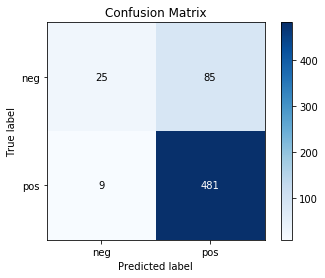

In [106]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test, pred, normalize=False)


In [107]:
print(classification_report(y_test ,pred))




             precision    recall  f1-score   support

        neg       0.74      0.23      0.35       110
        pos       0.85      0.98      0.91       490

avg / total       0.83      0.84      0.81       600



In [108]:
print("Accuracy of model  is ",round(accuracy_score(y_test ,pred),3))

Accuracy of model  is  0.843


## Observation:<br>

#### 1) The optimal value of Alpha is 0.0100 <br>

#### 2) True Negative Rate is low compare to true positive rate means model is not predicting well for negative review<br>

#### 3) The precision , recall and F1-Score are  83, 84,81 percentage respectively <br>

#### 4) Accuracy of our model using TF-IDF is 84.3 percentage


## [1.6] Feature Importance <br>



In [109]:
all_feat = tf_idf_vect.get_feature_names()


In [110]:
len(all_feat)


7473

In [111]:
model.class_count_

array([ 319., 1601.])

In [112]:
model.feature_log_prob_

array([[-11.98470667, -11.98470667, -11.98470667, ...,  -9.87044772,
        -11.98470667, -11.98470667],
       [-13.54967037, -10.42651028,  -9.72673624, ..., -13.54967037,
        -10.39092931, -10.39233963]])

#### model.class_counts_ is telling that model has 2 class and one class have 305 data of same class label in this case they belong to negative class and other class  1615 data of same class label in this case they belong to Positive class.<br>

#### model.feature_log_prob_ is calculating log probability of both the class

In [113]:
df = pd.DataFrame(model.feature_log_prob_,columns=all_feat)


In [114]:
df.shape

(2, 7473)

In [115]:
df.head()

,aaahhh,aah,aand,aback,abd,abhor,abil,abl,abroa,abrupt,...,zip,zipfizz,ziploc,zit,zombi,zon,zoo,zoonot,zucchini,zuke
0,-11.984707,-11.984707,-11.984707,-11.984707,-8.989867,-10.44470,-11.984707,-8.389703,-11.984707,-11.984707,...,-11.984707,-11.984707,-10.243325,-11.984707,-11.984707,-11.984707,-11.984707,-9.870448,-11.984707,-11.984707
1,-13.549670,-10.426510,-9.726736,-10.717083,-13.549670,-13.54967,-9.530099,-6.810858,-13.549670,-11.493808,...,-9.188585,-10.310415,-9.067406,-13.549670,-9.448571,-10.293944,-9.890634,-13.549670,-10.390929,-10.392340


In [116]:
df = df.T
df.shape

(7473, 2)

In [117]:
df.head(2)

,0,1
aaahhh,-11.984707,-13.54967
aah,-11.984707,-10.42651


In [118]:
top_neg_word = df[0].sort_values(ascending = False)[0:20] ## Finding Top  Negative value is negative class


In [119]:
top_neg_word

tast         -4.896722
like         -5.018552
product      -5.221413
flavor       -5.315155
tri          -5.439839
one          -5.463244
coffe        -5.477473
buy          -5.482084
would        -5.502790
order        -5.642369
dont         -5.701276
get          -5.707269
even         -5.708939
disappoint   -5.727682
tea          -5.732082
cat          -5.732087
use          -5.777252
could        -5.786449
good         -5.790096
bought       -5.815150
Name: 0, dtype: float64

In [120]:
top_positive_word= df[1].sort_values(ascending = False)[0:20] #Finding top positive value 

In [121]:
top_positive_word

great     -5.069315
good      -5.102505
love      -5.133353
flavor    -5.141393
tast      -5.143990
tea       -5.156115
coffe     -5.201723
use       -5.238212
like      -5.246571
product   -5.321171
one       -5.418350
tri       -5.435573
make      -5.546031
best      -5.608180
price     -5.612980
get       -5.616147
buy       -5.650056
amazon    -5.676492
find      -5.685616
order     -5.698486
Name: 1, dtype: float64